In [1]:
# 폰트 파일 확인 및 다운로드
import os
import urllib.request

font_path = 'NanumGothic.ttf'
if not os.path.exists(font_path):
    print("나눔고딕 폰트 다운로드 중...")
    url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
    urllib.request.urlretrieve(url, font_path)
    print(f"✓ {font_path} 다운로드 완료")
else:
    print(f"✓ {font_path} 파일이 이미 존재합니다.")

✓ NanumGothic.ttf 파일이 이미 존재합니다.


# UCI-SECOM 반도체 수율 시계열 분석

## 분석 목표
- **시간대별 불량률 분석**: 하루 24시간 중 불량이 가장 많이 발생하는 시간대
- **요일별 불량률 분석**: 주중/주말 불량률 차이
- **월별/일별 불량률 분석**: 시기별 불량 패턴
- **불량률 개선을 위한 인사이트 도출**

---

## 1. 라이브러리 임포트 및 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
import warnings
import os
import shutil
import matplotlib as mpl

warnings.filterwarnings('ignore')

# 폰트 캐시 완전 삭제
cache_dir = mpl.get_cachedir()
if os.path.exists(cache_dir):
    try:
        shutil.rmtree(cache_dir)
        print("✓ 폰트 캐시 삭제 완료")
    except Exception as e:
        print(f"⚠ 폰트 캐시 삭제 실패: {e}")

# 폰트 매니저 재로드
fm._load_fontmanager(try_read_cache=False)
fm.fontManager.ttflist = [f for f in fm.fontManager.ttflist if hasattr(f, 'name')]

# 시각화 스타일 설정 (먼저 적용)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 블로그 참고: https://super-son.tistory.com/40
# 로컬 나눔고딕 폰트 직접 적용
font_path = os.path.abspath('NanumGothic.ttf')
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = [font_name]
    plt.rcParams['font.sans-serif'] = [font_name]
    print(f"✓ 한글 폰트 설정 완료: {font_name}")
else:
    fallback_font = 'Malgun Gothic'
    plt.rcParams['font.family'] = [fallback_font]
    plt.rcParams['font.sans-serif'] = [fallback_font, 'DejaVu Sans']
    print("⚠ 로컬 나눔고딕 없음, 맑은 고딕 사용")

plt.rcParams['axes.unicode_minus'] = False

print("✓ 라이브러리 임포트 완료")

✓ 폰트 캐시 삭제 완료


Could not save font_manager cache [Errno 2] No such file or directory: 'C:\\Users\\alsgu\\.matplotlib\\fontlist-v390.json.matplotlib-lock'


✓ 한글 폰트 설정 완료: NanumGothic
✓ 라이브러리 임포트 완료


In [3]:
# 현재 사용 중인 폰트 확인
print("\n현재 matplotlib 폰트 설정:")
print(f"font.family: {plt.rcParams['font.family']}")
print(f"font.sans-serif: {plt.rcParams.get('font.sans-serif', 'N/A')}")

# 시스템에 설치된 한글 폰트 확인
print("\n시스템에 설치된 한글 폰트:")
korean_fonts = []
for f in fm.fontManager.ttflist:
    name = getattr(f, 'name', None)
    if not name:
        continue
    if any(key in name for key in ['Gothic', 'Malgun', 'Nanum']):
        korean_fonts.append(name)
for font in list(sorted(set(korean_fonts)))[:5]:
    print(f"  - {font}")
if not korean_fonts:
    print("  - (한글 폰트 없음)")


현재 matplotlib 폰트 설정:
font.family: ['NanumGothic']
font.sans-serif: ['NanumGothic']

시스템에 설치된 한글 폰트:
  - BIZ UDGothic
  - Century Gothic
  - Copperplate Gothic Bold
  - Copperplate Gothic Light
  - Franklin Gothic Book


## 2. 데이터 로드 및 전처리

In [4]:
# Forward/Backward Fill로 처리된 데이터 로드
df = pd.read_csv('uci-secom_method4_ffill_bfill.csv')

print("=" * 70)
print("데이터 기본 정보")
print("=" * 70)
print(f"데이터 형태: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist()[:10], "...")  # 처음 10개만 표시
print(f"\n처음 5개 행:")
df.head()

데이터 기본 정보
데이터 형태: (1567, 584)

컬럼 목록:
['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8'] ...

처음 5개 행:


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,208.2045,0.5005,0.0118,0.0035,2.3630,0.0096,0.0201,0.0060,208.2045,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,73.8432,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [5]:
# Time 컬럼을 datetime 형식으로 변환
df['Time'] = pd.to_datetime(df['Time'])

# 시간 관련 특징 추출
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour
df['DayOfWeek'] = df['Time'].dt.dayofweek  # 0=월요일, 6=일요일
df['DayName'] = df['Time'].dt.day_name()
df['Date'] = df['Time'].dt.date

# Pass/Fail 컬럼 확인 (1=불량, -1=정상)
print("\n" + "=" * 70)
print("Pass/Fail 분포")
print("=" * 70)
print(df['Pass/Fail'].value_counts())
print(f"\n총 샘플 수: {len(df)}")
print(f"불량 샘플 수: {(df['Pass/Fail'] == 1).sum()}")
print(f"정상 샘플 수: {(df['Pass/Fail'] == -1).sum()}")
print(f"전체 불량률: {(df['Pass/Fail'] == 1).sum() / len(df) * 100:.2f}%")


Pass/Fail 분포
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

총 샘플 수: 1567
불량 샘플 수: 104
정상 샘플 수: 1463
전체 불량률: 6.64%


## 3. 시간대별 불량률 분석 (24시간)

In [6]:
# 시간대별 불량률 계산
hourly_stats = df.groupby('Hour').agg({
    'Pass/Fail': [
        ('총_샘플수', 'count'),
        ('불량_샘플수', lambda x: (x == 1).sum()),
        ('불량률(%)', lambda x: (x == 1).sum() / len(x) * 100)
    ]
}).round(2)

hourly_stats.columns = ['총_샘플수', '불량_샘플수', '불량률(%)']
hourly_stats = hourly_stats.reset_index()

print("=" * 70)
print("시간대별 불량률")
print("=" * 70)
print(hourly_stats)
print(f"\n가장 불량률이 높은 시간대: {hourly_stats.loc[hourly_stats['불량률(%)'].idxmax(), 'Hour']}시 ({hourly_stats['불량률(%)'].max():.2f}%)")
print(f"가장 불량률이 낮은 시간대: {hourly_stats.loc[hourly_stats['불량률(%)'].idxmin(), 'Hour']}시 ({hourly_stats['불량률(%)'].min():.2f}%)")

시간대별 불량률
    Hour  총_샘플수  불량_샘플수  불량률(%)
0      0     65       3    4.62
1      1     42       3    7.14
2      2     60       3    5.00
3      3     70       5    7.14
4      4     65       6    9.23
5      5     74       4    5.41
6      6     62       5    8.06
7      7     73       3    4.11
8      8     64       3    4.69
9      9     55       6   10.91
10    10     53       1    1.89
11    11     68       5    7.35
12    12     67       3    4.48
13    13     50       5   10.00
14    14     77       3    3.90
15    15     99      11   11.11
16    16     58       4    6.90
17    17     58       2    3.45
18    18     63       3    4.76
19    19     63       4    6.35
20    20     79       6    7.59
21    21     71       7    9.86
22    22     56       4    7.14
23    23     75       5    6.67

가장 불량률이 높은 시간대: 15시 (11.11%)
가장 불량률이 낮은 시간대: 10시 (1.89%)


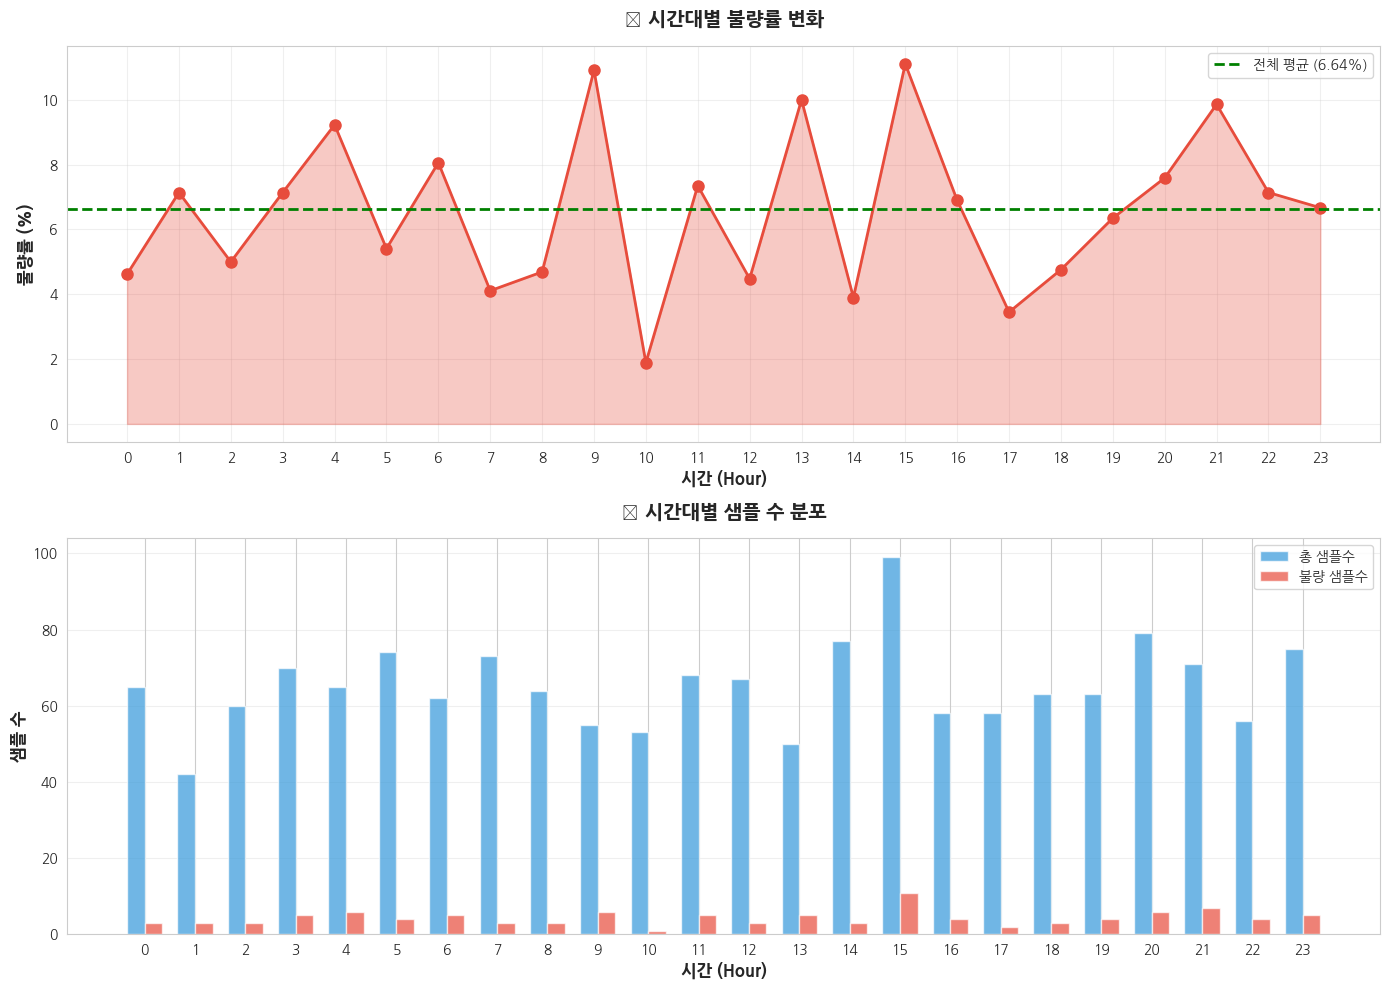


✓ 그래프 저장: hourly_defect_analysis.png


In [7]:
# 시간대별 불량률 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 그래프 1: 시간대별 불량률 라인 차트
axes[0].plot(hourly_stats['Hour'], hourly_stats['불량률(%)'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0].fill_between(hourly_stats['Hour'], hourly_stats['불량률(%)'], 
                      alpha=0.3, color='#e74c3c')
axes[0].set_xlabel('시간 (Hour)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[0].set_title('시간대별 불량률 변화', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

# 평균 불량률 라인 추가
avg_defect_rate = (df['Pass/Fail'] == 1).sum() / len(df) * 100
axes[0].axhline(y=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[0].legend(fontsize=10)

# 그래프 2: 시간대별 샘플 수와 불량 샘플 수
x = hourly_stats['Hour']
width = 0.35
axes[1].bar(x - width/2, hourly_stats['총_샘플수'], width, 
            label='총 샘플수', color='#3498db', alpha=0.7)
axes[1].bar(x + width/2, hourly_stats['불량_샘플수'], width, 
            label='불량 샘플수', color='#e74c3c', alpha=0.7)
axes[1].set_xlabel('시간 (Hour)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('샘플 수', fontsize=12, fontweight='bold')
axes[1].set_title('시간대별 샘플 수 분포', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.savefig('hourly_defect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 그래프 저장: hourly_defect_analysis.png")

## 4. 요일별 불량률 분석

In [8]:
# 요일별 불량률 계산
daily_stats = df.groupby(['DayOfWeek', 'DayName']).agg({
    'Pass/Fail': [
        ('총_샘플수', 'count'),
        ('불량_샘플수', lambda x: (x == 1).sum()),
        ('불량률(%)', lambda x: (x == 1).sum() / len(x) * 100)
    ]
}).round(2)

daily_stats.columns = ['총_샘플수', '불량_샘플수', '불량률(%)']
daily_stats = daily_stats.reset_index()

# 요일 순서 정렬
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_stats['DayName'] = pd.Categorical(daily_stats['DayName'], categories=day_order, ordered=True)
daily_stats = daily_stats.sort_values('DayName')

print("=" * 70)
print("요일별 불량률")
print("=" * 70)
print(daily_stats)
print(f"\n가장 불량률이 높은 요일: {daily_stats.loc[daily_stats['불량률(%)'].idxmax(), 'DayName']} ({daily_stats['불량률(%)'].max():.2f}%)")
print(f"가장 불량률이 낮은 요일: {daily_stats.loc[daily_stats['불량률(%)'].idxmin(), 'DayName']} ({daily_stats['불량률(%)'].min():.2f}%)")

요일별 불량률
   DayOfWeek    DayName  총_샘플수  불량_샘플수  불량률(%)
0          0     Monday    183      11    6.01
1          1    Tuesday    234      18    7.69
2          2  Wednesday    187      19   10.16
3          3   Thursday    251       9    3.59
4          4     Friday    188      12    6.38
5          5   Saturday    287      16    5.57
6          6     Sunday    237      19    8.02

가장 불량률이 높은 요일: Wednesday (10.16%)
가장 불량률이 낮은 요일: Thursday (3.59%)


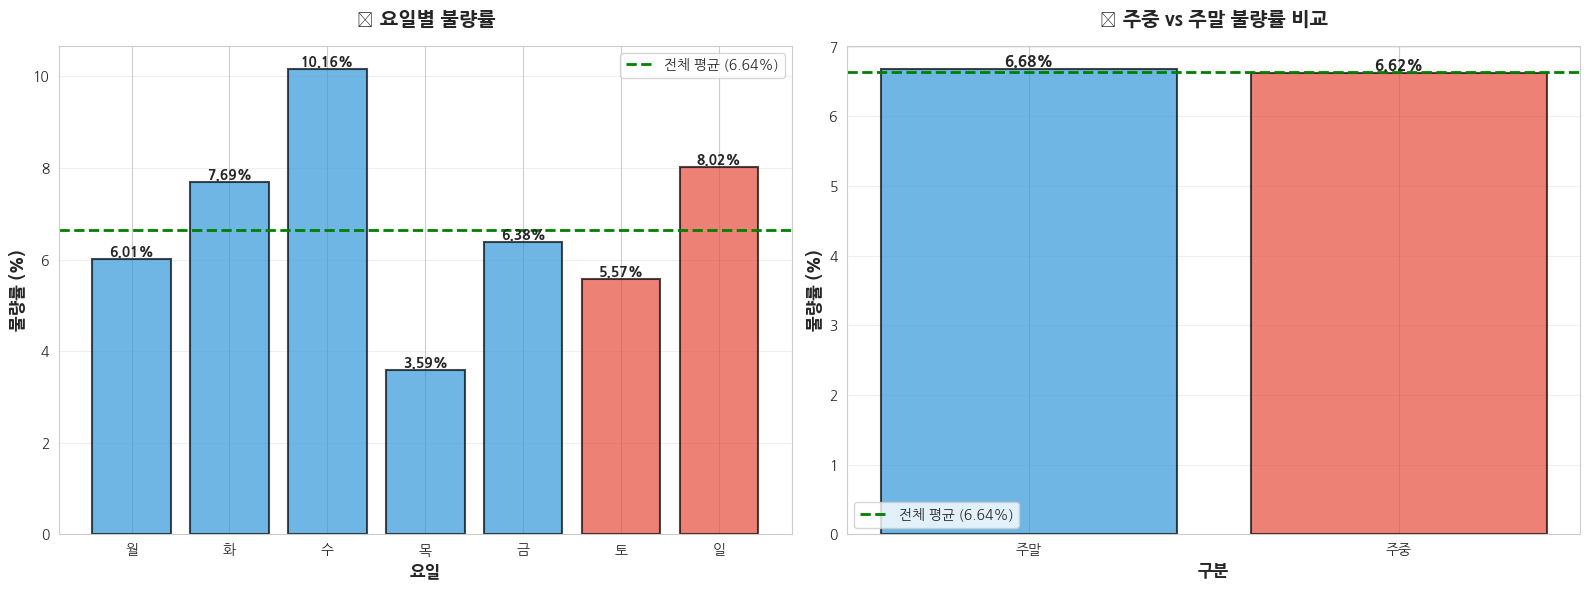


✓ 그래프 저장: daily_defect_analysis.png


In [9]:
# 요일별 불량률 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 한글 요일명으로 변환
day_korean = {
    'Monday': '월', 'Tuesday': '화', 'Wednesday': '수', 
    'Thursday': '목', 'Friday': '금', 'Saturday': '토', 'Sunday': '일'
}
daily_stats['요일'] = daily_stats['DayName'].map(day_korean)

# 그래프 1: 요일별 불량률
colors = ['#3498db' if i < 5 else '#e74c3c' for i in range(len(daily_stats))]
bars = axes[0].bar(daily_stats['요일'], daily_stats['불량률(%)'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[0].set_xlabel('요일', fontsize=12, fontweight='bold')
axes[0].set_ylabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[0].set_title('요일별 불량률', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 그래프 2: 주중 vs 주말 비교
df['주중/주말'] = df['DayOfWeek'].apply(lambda x: '주말' if x >= 5 else '주중')
weekend_stats = df.groupby('주중/주말').agg({
    'Pass/Fail': [
        ('총_샘플수', 'count'),
        ('불량률(%)', lambda x: (x == 1).sum() / len(x) * 100)
    ]
}).round(2)
weekend_stats.columns = ['총_샘플수', '불량률(%)']
weekend_stats = weekend_stats.reset_index()

colors2 = ['#3498db', '#e74c3c']
bars2 = axes[1].bar(weekend_stats['주중/주말'], weekend_stats['불량률(%)'], 
                    color=colors2, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[1].set_xlabel('구분', fontsize=12, fontweight='bold')
axes[1].set_ylabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[1].set_title('주중 vs 주말 불량률 비교', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('daily_defect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 그래프 저장: daily_defect_analysis.png")

## 월별 불량률 분석

In [10]:
# 월별 불량률 계산
monthly_stats = df.groupby('Month').agg({
    'Pass/Fail': [
        ('총_샘플수', 'count'),
        ('불량_개수', lambda x: (x == 1).sum()),
        ('불량률(%)', lambda x: (x == 1).sum() / len(x) * 100)
    ]
}).round(2)

monthly_stats.columns = ['총_샘플수', '불량_개수', '불량률(%)']
monthly_stats = monthly_stats.reset_index()

print("=" * 70)
print("월별 불량률 통계")
print("=" * 70)
print(monthly_stats.to_string(index=False))
print("\n" + "=" * 70)
print(f"불량률이 가장 높은 달: {monthly_stats.loc[monthly_stats['불량률(%)'].idxmax(), 'Month']}월 "
      f"({monthly_stats['불량률(%)'].max():.2f}%)")
print(f"불량률이 가장 낮은 달: {monthly_stats.loc[monthly_stats['불량률(%)'].idxmin(), 'Month']}월 "
      f"({monthly_stats['불량률(%)'].min():.2f}%)")
print("=" * 70)

📅 월별 불량률 통계
 Month  총_샘플수  불량_개수  불량률(%)
     1     51      3    5.88
     2     98      5    5.10
     3     50      1    2.00
     4     49      3    6.12
     5     62      7   11.29
     6     67      6    8.96
     7    114     16   14.04
     8    471     38    8.07
     9    413     17    4.12
    10    123      6    4.88
    11     35      2    5.71
    12     34      0    0.00

📌 불량률이 가장 높은 달: 7월 (14.04%)
📌 불량률이 가장 낮은 달: 12월 (0.00%)


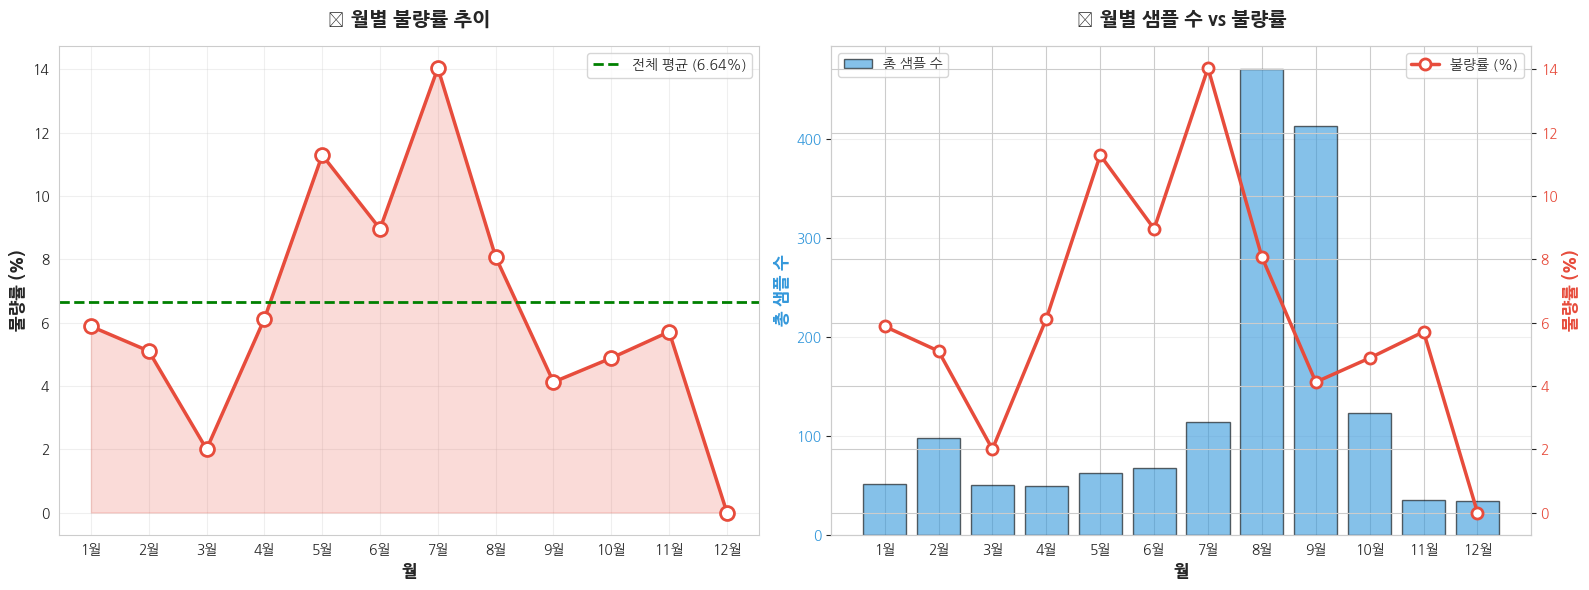


✓ 그래프 저장: monthly_defect_analysis.png


In [ ]:
# 월별 불량률 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 그래프 1: 월별 불량률 라인 차트
month_names = ['1월', '2월', '3월', '4월', '5월', '6월', 
               '7월', '8월', '9월', '10월', '11월', '12월']
axes[0].plot(monthly_stats['Month'], monthly_stats['불량률(%)'], 
             marker='o', linewidth=2.5, markersize=10, color='#e74c3c', 
             markerfacecolor='white', markeredgewidth=2, markeredgecolor='#e74c3c')
axes[0].fill_between(monthly_stats['Month'], monthly_stats['불량률(%)'], 
                      alpha=0.2, color='#e74c3c')
axes[0].axhline(y=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[0].set_xlabel('월', fontsize=12, fontweight='bold')
axes[0].set_ylabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[0].set_title('월별 불량률 추이', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(monthly_stats['Month'])
axes[0].set_xticklabels([month_names[m-1] for m in monthly_stats['Month']], rotation=0)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 그래프 2: 월별 샘플 수와 불량률
ax2 = axes[1]
ax2_twin = ax2.twinx()

# 샘플 수 막대 그래프
bars = ax2.bar(monthly_stats['Month'], monthly_stats['총_샘플수'], 
               alpha=0.6, color='#3498db', label='총 샘플 수', edgecolor='black', linewidth=1)
ax2.set_xlabel('월', fontsize=12, fontweight='bold')
ax2.set_ylabel('총 샘플 수', fontsize=12, fontweight='bold', color='#3498db')
ax2.tick_params(axis='y', labelcolor='#3498db')
ax2.set_xticks(monthly_stats['Month'])
ax2.set_xticklabels([month_names[m-1] for m in monthly_stats['Month']], rotation=0)

# 불량률 라인 그래프
line = ax2_twin.plot(monthly_stats['Month'], monthly_stats['불량률(%)'], 
                     marker='o', linewidth=2.5, markersize=8, color='#e74c3c', 
                     label='불량률 (%)', markerfacecolor='white', 
                     markeredgewidth=2, markeredgecolor='#e74c3c')
ax2_twin.set_ylabel('불량률 (%)', fontsize=12, fontweight='bold', color='#e74c3c')
ax2_twin.tick_params(axis='y', labelcolor='#e74c3c')

ax2.set_title('월별 샘플 수 vs 불량률', fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('monthly_defect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 그래프 저장: monthly_defect_analysis.png")

## 🗓️ 날짜별 불량률 분석

In [12]:
# 날짜별 불량률 계산 (상위 10개 불량률 날짜)
date_stats = df.groupby('Date').agg({
    'Pass/Fail': [
        ('총_샘플수', 'count'),
        ('불량_개수', lambda x: (x == 1).sum()),
        ('불량률(%)', lambda x: (x == 1).sum() / len(x) * 100)
    ]
}).round(2)

date_stats.columns = ['총_샘플수', '불량_개수', '불량률(%)']
date_stats = date_stats.reset_index()

# 불량률 상위 10개 날짜
top10_defect_dates = date_stats.nlargest(10, '불량률(%)')

print("=" * 80)
print("불량률 상위 10개 날짜")
print("=" * 80)
print(top10_defect_dates.to_string(index=False))
print("\n" + "=" * 80)

# 불량률 하위 10개 날짜 (0%가 아닌 날짜)
bottom10_defect_dates = date_stats[date_stats['불량률(%)'] > 0].nsmallest(10, '불량률(%)')
print("불량률 하위 10개 날짜 (0% 제외)")
print("=" * 80)
print(bottom10_defect_dates.to_string(index=False))
print("=" * 80)

⚠️  불량률 상위 10개 날짜
      Date  총_샘플수  불량_개수  불량률(%)
2008-07-25      1      1  100.00
2008-07-21      2      1   50.00
2008-10-08     12      5   41.67
2008-07-30      5      2   40.00
2008-07-29     12      4   33.33
2008-08-17     17      5   29.41
2008-07-19     12      3   25.00
2008-07-28      8      2   25.00
2008-07-31      4      1   25.00
2008-09-10      8      2   25.00

✅ 불량률 하위 10개 날짜 (0% 제외)
      Date  총_샘플수  불량_개수  불량률(%)
2008-08-28     43      1    2.33
2008-10-15     34      1    2.94
2008-05-08     28      1    3.57
2008-07-10     28      1    3.57
2008-01-09     26      1    3.85
2008-08-29     50      2    4.00
2008-08-30     49      2    4.08
2008-09-23     24      1    4.17
2008-09-24     23      1    4.35
2008-09-29     21      1    4.76


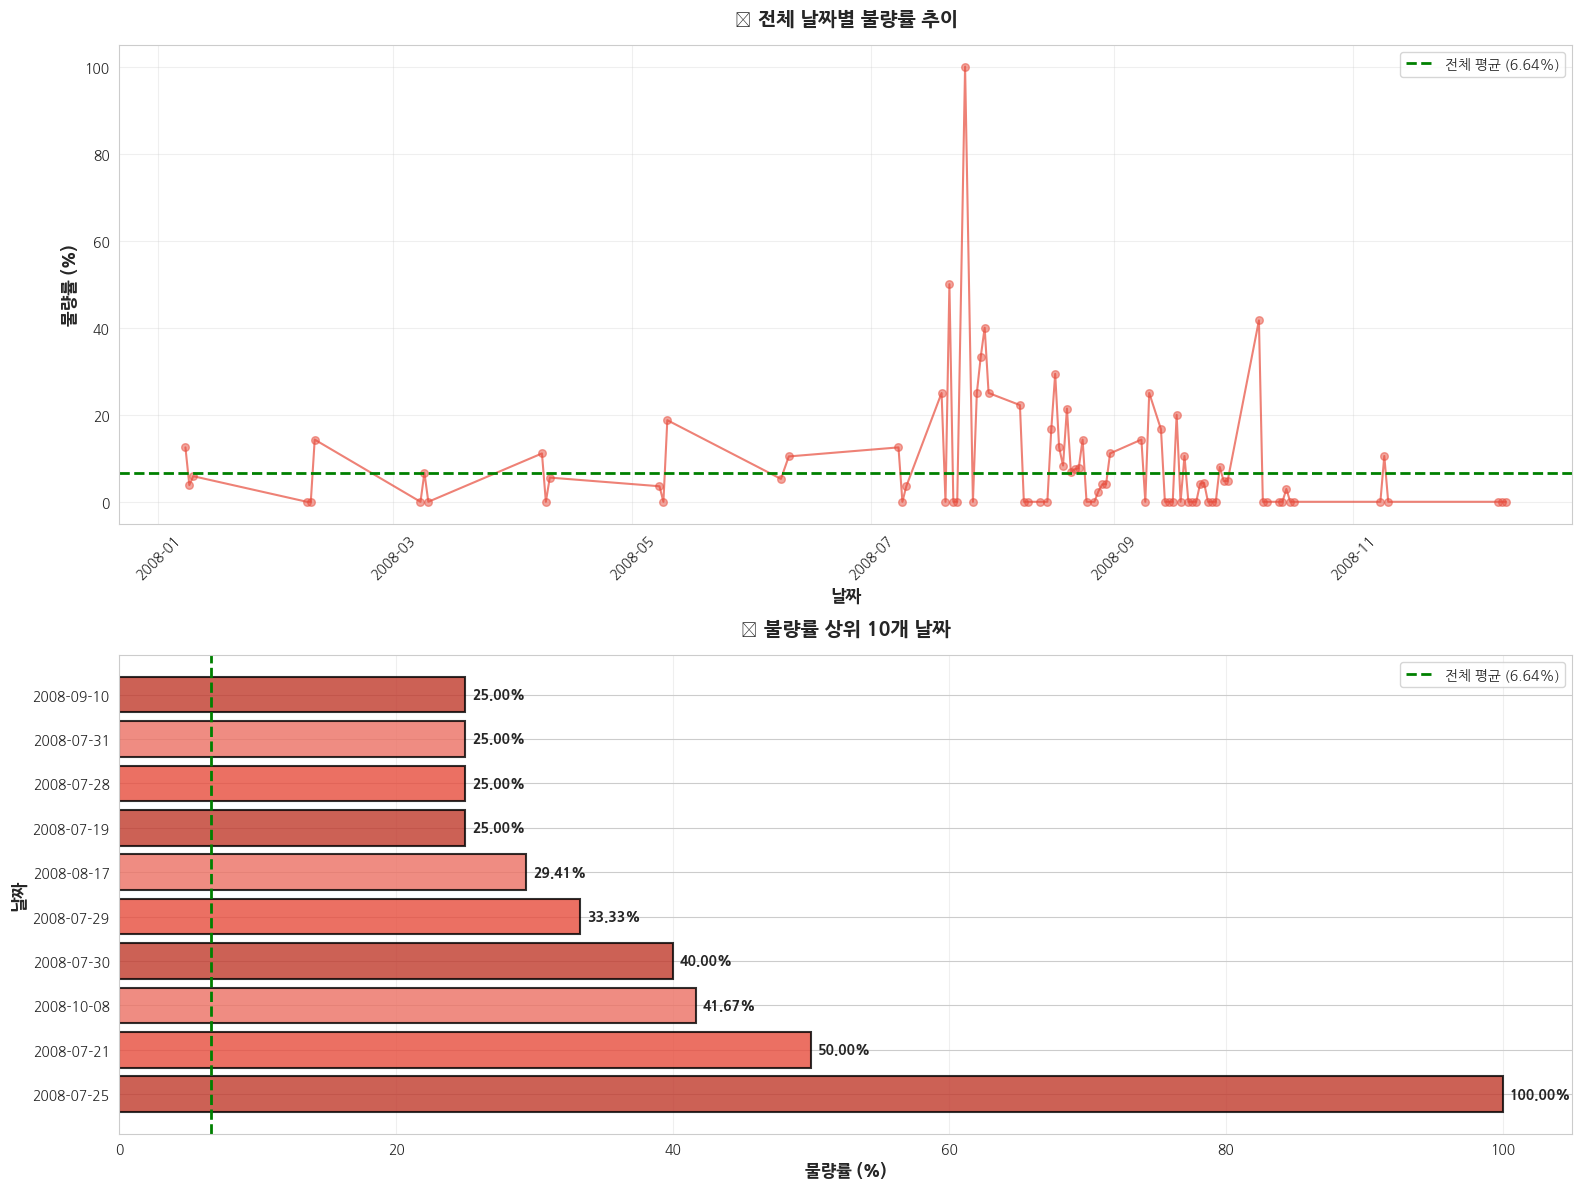


✓ 그래프 저장: date_defect_analysis.png


In [13]:
# 날짜별 불량률 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 그래프 1: 전체 날짜별 불량률 추이
axes[0].plot(date_stats['Date'], date_stats['불량률(%)'], 
             linewidth=1.5, alpha=0.7, color='#e74c3c')
axes[0].scatter(date_stats['Date'], date_stats['불량률(%)'], 
                s=30, alpha=0.5, color='#e74c3c')
axes[0].axhline(y=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[0].set_xlabel('날짜', fontsize=12, fontweight='bold')
axes[0].set_ylabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[0].set_title('전체 날짜별 불량률 추이', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 그래프 2: 불량률 상위 10개 날짜
colors = ['#c0392b', '#e74c3c', '#ec7063'] * 4
bars = axes[1].barh(range(len(top10_defect_dates)), top10_defect_dates['불량률(%)'], 
                    color=colors[:len(top10_defect_dates)], 
                    alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(top10_defect_dates)))
axes[1].set_yticklabels([str(d)[:10] for d in top10_defect_dates['Date']])
axes[1].set_xlabel('불량률 (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('날짜', fontsize=12, fontweight='bold')
axes[1].set_title('불량률 상위 10개 날짜', fontsize=14, fontweight='bold', pad=15)
axes[1].axvline(x=avg_defect_rate, color='green', linestyle='--', 
                linewidth=2, label=f'전체 평균 ({avg_defect_rate:.2f}%)')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

# 막대 옆에 값 표시
for i, (bar, val) in enumerate(zip(bars, top10_defect_dates['불량률(%)'])):
    axes[1].text(val + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('date_defect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 그래프 저장: date_defect_analysis.png")

## 🔥 시간대 × 요일 히트맵 분석

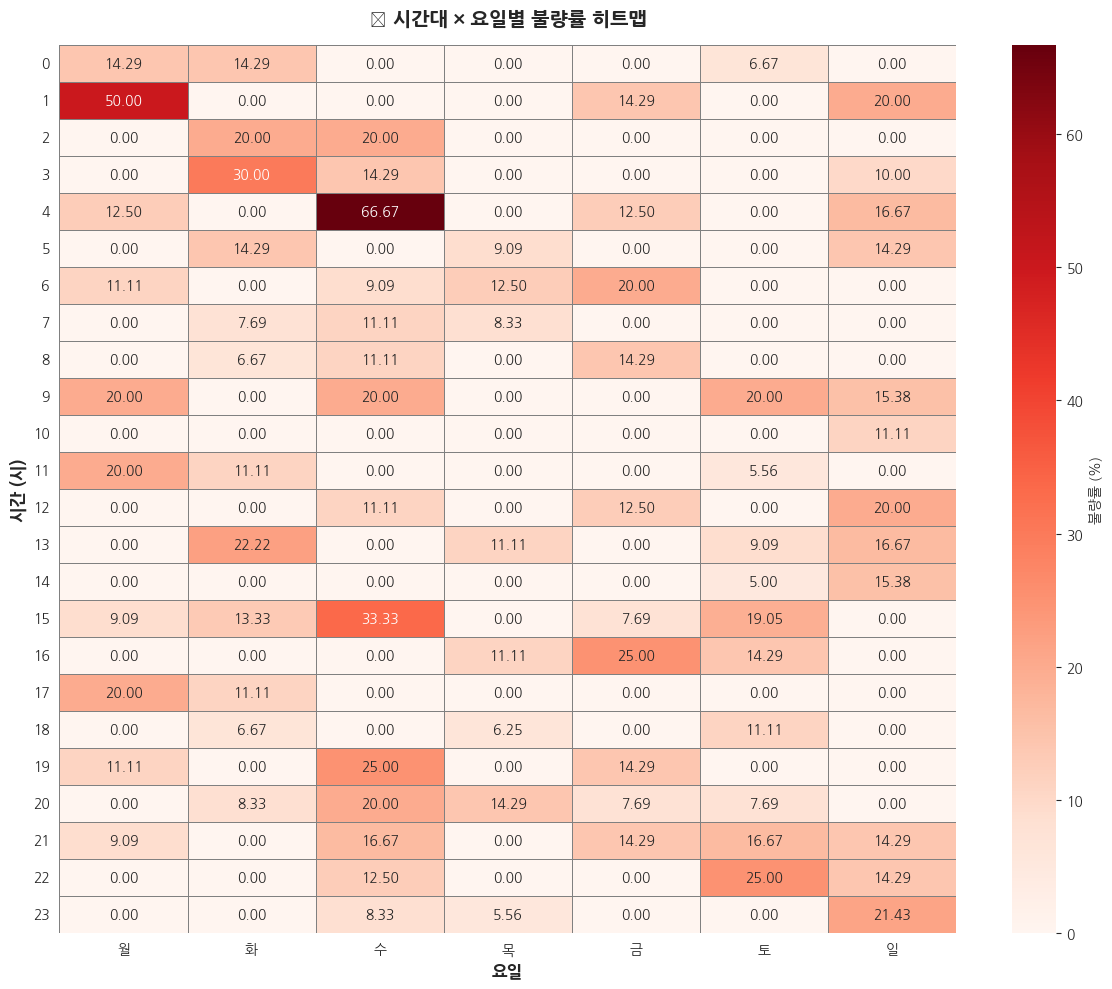


✓ 그래프 저장: hour_day_heatmap.png

🚨 가장 높은 불량률: 수 4시 (66.67%)


In [ ]:
# 시간대 × 요일 불량률 히트맵
heatmap_data = df.groupby(['Hour', 'DayOfWeek']).agg({
    'Pass/Fail': lambda x: (x == 1).sum() / len(x) * 100
}).reset_index()

# 피벗 테이블 생성
heatmap_pivot = heatmap_data.pivot(index='Hour', columns='DayOfWeek', values='Pass/Fail')

# 요일 이름으로 컬럼명 변경
day_names_kr = ['월', '화', '수', '목', '금', '토', '일']
heatmap_pivot.columns = day_names_kr

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=True, fmt='.2f', cmap='Reds', 
            linewidths=0.5, linecolor='gray', cbar_kws={'label': '불량률 (%)'}, ax=ax)
ax.set_xlabel('요일', fontsize=12, fontweight='bold')
ax.set_ylabel('시간 (시)', fontsize=12, fontweight='bold')
ax.set_title('시간대 × 요일별 불량률 히트맵', fontsize=14, fontweight='bold', pad=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('hour_day_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 그래프 저장: hour_day_heatmap.png")

# 가장 높은 불량률 조합 찾기
max_defect_idx = heatmap_data['Pass/Fail'].idxmax()
max_defect_hour = heatmap_data.loc[max_defect_idx, 'Hour']
max_defect_day = heatmap_data.loc[max_defect_idx, 'DayOfWeek']
max_defect_rate = heatmap_data.loc[max_defect_idx, 'Pass/Fail']

print("\n" + "=" * 70)
print(f"🚨 가장 높은 불량률: {day_names_kr[max_defect_day]} {max_defect_hour}시 ({max_defect_rate:.2f}%)")
print("=" * 70)

## 💡 불량 감소를 위한 인사이트 및 권장사항

In [15]:
# 종합 인사이트 생성
print("=" * 90)
print("📊 반도체 제조 공정 불량률 분석 - 종합 인사이트")
print("=" * 90)

# 1. 시간대별 인사이트
best_hour = hourly_stats.loc[hourly_stats['불량률(%)'].idxmin(), 'Hour']
worst_hour = hourly_stats.loc[hourly_stats['불량률(%)'].idxmax(), 'Hour']
best_hour_rate = hourly_stats.loc[hourly_stats['불량률(%)'].idxmin(), '불량률(%)']
worst_hour_rate = hourly_stats.loc[hourly_stats['불량률(%)'].idxmax(), '불량률(%)']

print("\n🕐 시간대별 분석")
print("-" * 90)
print(f"  • 최저 불량률 시간대: {best_hour}시 ({best_hour_rate:.2f}%)")
print(f"  • 최고 불량률 시간대: {worst_hour}시 ({worst_hour_rate:.2f}%)")
print(f"  • 시간대별 불량률 차이: {worst_hour_rate - best_hour_rate:.2f}%p")

# 2. 요일별 인사이트
best_day = daily_stats.loc[daily_stats['불량률(%)'].idxmin(), 'DayName']
worst_day = daily_stats.loc[daily_stats['불량률(%)'].idxmax(), 'DayName']
best_day_rate = daily_stats.loc[daily_stats['불량률(%)'].idxmin(), '불량률(%)']
worst_day_rate = daily_stats.loc[daily_stats['불량률(%)'].idxmax(), '불량률(%)']
weekday_rate = weekend_stats[weekend_stats['주중/주말'] == '주중']['불량률(%)'].values[0]
weekend_rate = weekend_stats[weekend_stats['주중/주말'] == '주말']['불량률(%)'].values[0]

print("\n📅 요일별 분석")
print("-" * 90)
print(f"  • 최저 불량률 요일: {best_day} ({best_day_rate:.2f}%)")
print(f"  • 최고 불량률 요일: {worst_day} ({worst_day_rate:.2f}%)")
print(f"  • 주중 평균 불량률: {weekday_rate:.2f}%")
print(f"  • 주말 평균 불량률: {weekend_rate:.2f}%")
print(f"  • 주중/주말 차이: {abs(weekday_rate - weekend_rate):.2f}%p")

# 3. 월별 인사이트
best_month = monthly_stats.loc[monthly_stats['불량률(%)'].idxmin(), 'Month']
worst_month = monthly_stats.loc[monthly_stats['불량률(%)'].idxmax(), 'Month']
best_month_rate = monthly_stats.loc[monthly_stats['불량률(%)'].idxmin(), '불량률(%)']
worst_month_rate = monthly_stats.loc[monthly_stats['불량률(%)'].idxmax(), '불량률(%)']

print("\n📆 월별 분석")
print("-" * 90)
print(f"  • 최저 불량률 월: {best_month}월 ({best_month_rate:.2f}%)")
print(f"  • 최고 불량률 월: {worst_month}월 ({worst_month_rate:.2f}%)")
print(f"  • 월별 불량률 차이: {worst_month_rate - best_month_rate:.2f}%p")

# 4. 날짜별 인사이트
high_defect_dates_count = len(date_stats[date_stats['불량률(%)'] > avg_defect_rate * 1.5])
zero_defect_dates_count = len(date_stats[date_stats['불량률(%)'] == 0])

print("\n🗓️  날짜별 분석")
print("-" * 90)
print(f"  • 평균의 1.5배 이상 불량률을 보인 날짜: {high_defect_dates_count}일")
print(f"  • 불량률 0%를 달성한 날짜: {zero_defect_dates_count}일")
print(f"  • 최고 불량률 날짜: {top10_defect_dates.iloc[0]['Date']} ({top10_defect_dates.iloc[0]['불량률(%)']:.2f}%)")

print("\n" + "=" * 90)
print("💡 불량 감소를 위한 권장사항")
print("=" * 90)

recommendations = []

# 시간대 기반 권장사항
if worst_hour_rate > avg_defect_rate * 1.2:
    recommendations.append(
        f"1. 🕐 시간대 집중 관리\n"
        f"   - {worst_hour}시에 불량률이 {worst_hour_rate:.2f}%로 가장 높습니다.\n"
        f"   - 해당 시간대에 장비 상태 점검 및 공정 파라미터 모니터링을 강화하세요.\n"
        f"   - {best_hour}시의 공정 조건({best_hour_rate:.2f}%)을 벤치마크로 활용하세요."
    )

# 요일 기반 권장사항
if abs(weekday_rate - weekend_rate) > 1.0:
    if weekend_rate > weekday_rate:
        recommendations.append(
            f"2. 📅 주말 운영 개선\n"
            f"   - 주말 불량률({weekend_rate:.2f}%)이 주중({weekday_rate:.2f}%)보다 높습니다.\n"
            f"   - 주말 인력 배치 및 장비 유지보수 스케줄을 재검토하세요.\n"
            f"   - 주말 전 금요일에 예방 정비를 실시하세요."
        )
    else:
        recommendations.append(
            f"2. 📅 주중 운영 개선\n"
            f"   - 주중 불량률({weekday_rate:.2f}%)이 주말({weekend_rate:.2f}%)보다 높습니다.\n"
            f"   - 주중 생산량 증가에 따른 공정 부하를 확인하세요.\n"
            f"   - 교대 근무 시 인수인계 절차를 강화하세요."
        )

# 월별 기반 권장사항
if worst_month_rate > avg_defect_rate * 1.3:
    recommendations.append(
        f"3. 📆 계절적 요인 관리\n"
        f"   - {worst_month}월에 불량률이 {worst_month_rate:.2f}%로 급증합니다.\n"
        f"   - 온도, 습도 등 환경 조건의 영향을 분석하세요.\n"
        f"   - {worst_month}월 이전에 장비 정밀 점검 및 캘리브레이션을 실시하세요."
    )

# 날짜별 기반 권장사항
if high_defect_dates_count > 0:
    recommendations.append(
        f"4. 🚨 고위험 날짜 패턴 분석\n"
        f"   - {high_defect_dates_count}일간 평균보다 1.5배 이상 높은 불량률이 발생했습니다.\n"
        f"   - 해당 날짜들의 공통 요인(장비 이벤트, 원자재 배치 등)을 분석하세요.\n"
        f"   - 실시간 SPC(Statistical Process Control) 시스템을 도입하여 조기 경보를 받으세요."
    )

# 전반적 권장사항
recommendations.append(
    f"5. 📊 전반적 개선 방안\n"
    f"   - 현재 전체 불량률: {avg_defect_rate:.2f}%\n"
    f"   - 시간대/요일별 패턴을 활용한 예측 모델을 구축하세요.\n"
    f"   - 불량률 0% 날짜({zero_defect_dates_count}일)의 성공 사례를 분석하여 표준화하세요.\n"
    f"   - 센서 데이터(592개 특성)와 불량 패턴 간의 상관관계를 머신러닝으로 분석하세요."
)

for rec in recommendations:
    print(f"\n{rec}")

print("\n" + "=" * 90)
print("✅ 분석 완료")
print("=" * 90)

📊 반도체 제조 공정 불량률 분석 - 종합 인사이트

🕐 시간대별 분석
------------------------------------------------------------------------------------------
  • 최저 불량률 시간대: 10시 (1.89%)
  • 최고 불량률 시간대: 15시 (11.11%)
  • 시간대별 불량률 차이: 9.22%p

📅 요일별 분석
------------------------------------------------------------------------------------------
  • 최저 불량률 요일: Thursday (3.59%)
  • 최고 불량률 요일: Wednesday (10.16%)
  • 주중 평균 불량률: 6.62%
  • 주말 평균 불량률: 6.68%
  • 주중/주말 차이: 0.06%p

📆 월별 분석
------------------------------------------------------------------------------------------
  • 최저 불량률 월: 12월 (0.00%)
  • 최고 불량률 월: 7월 (14.04%)
  • 월별 불량률 차이: 14.04%p

🗓️  날짜별 분석
------------------------------------------------------------------------------------------
  • 평균의 1.5배 이상 불량률을 보인 날짜: 27일
  • 불량률 0%를 달성한 날짜: 39일
  • 최고 불량률 날짜: 2008-07-25 (100.00%)

💡 불량 감소를 위한 권장사항

1. 🕐 시간대 집중 관리
   - 15시에 불량률이 11.11%로 가장 높습니다.
   - 해당 시간대에 장비 상태 점검 및 공정 파라미터 모니터링을 강화하세요.
   - 10시의 공정 조건(1.89%)을 벤치마크로 활용하세요.

3. 📆 계절적 요인 관리
   - 7월에 불량률이 14.04%로 급증